In [1]:
%matplotlib ipympl

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skdh

plt.style.use('ggplot')

# Exploring the data and loading it into memory

We'll start with an example file that contains 3 minutes of recording

In [3]:
path_example_2min = "example_data_2min.csv"

Lets first see what the data format looks like, so we know how we have to read it in the future

In [4]:
df = pd.read_csv(path_example_2min)
df.head(3)

,1572339786.3000,-0.518555,-0.023926,-0.077148,-66.223145,-27.221678,104.736320
0,1.572340e+09,-0.641113,-0.048828,-0.102051,-66.223145,-27.221678,104.736320
1,1.572340e+09,-0.690918,-0.088379,-0.094727,-64.636230,-27.038572,104.187004
2,1.572340e+09,-0.584961,-0.097656,-0.115234,-66.833496,-28.137205,100.341789


We can see that the file contains no header information, but what appears to be a timestamp column, followed by 6 data columns. Knowing this came from an Axivity Ax6 device, we can assume then that the first 3 columns are the X/Y/Z acceleration, and the last 3 are the X/Y/Z angular velocity measurements.

Next, we can take a look at how we might read this in using SKDH. For this we have 2 options:

1. Lookup the documentation on the online documentation page, https://scikit-digital-health.readthedocs.io/en/latest/
   ![SKDH readthedocs](images/skdh_rtd.png "SKDH readthedocs")

   From the home-page we can navigate to the API reference either through the header/top-bar link, or by clicking one of the SKDH module images on the main page, such as `IO` for our case:

   ![SKDH API IO](images/skdh_rtd_api_io.png "SKDH API reference IO page")

   Then from this, page, since we know we are interested in a CSV file, we can click on the `ReadCSV` method to learn more:
   ![SKDH API ReadCSV](images/skdh_rtd_api_io_readcsv.png "SKDH API reference ReadCSV")

2. Alternatively, we can query the help information directly in python for this method:

In [5]:
help(skdh.io.ReadCSV)

Help on class ReadCSV in module skdh.io.csv:

class ReadCSV(skdh.io.base.BaseIO)
 |  ReadCSV(time_col_name, column_names, drop_duplicate_timestamps=False, trim_keys=None, fill_gaps=True, fill_value=None, gaps_error='raise', to_datetime_kwargs=None, raw_conversions=None, accel_in_g=True, g_value=9.81, read_csv_kwargs=None, ext_error='warn')
 |
 |  Read a comma-separated value (CSV) file into memory.
 |
 |  Parameters
 |  ----------
 |  time_col_name : str
 |      The name of the column containing timestamps.
 |  column_names : dict
 |      Dictionary of column names for different data types. See Notes.
 |  drop_duplicate_timestamps : bool, optional
 |      Drop duplicate timestamps before doing any timestamp handling or gap filling.
 |      Default is False.
 |  trim_keys : {None, tuple}, optional
 |      Trim keys provided in the `predict` method. Default (None) will not do any trimming.
 |      Trimming of either start or end can be accomplished by providing None in the place
 |      

Using the `help()` method we can see the docstrings for the object. Since `SKDH` uses classes, there are multiple class methods with docstrings. For now, we are only concerned with the main docstring, as this tells us how to initialize the class. We can use this to write the reader to read in the example CSV data.

In [6]:
rdr = skdh.io.ReadCSV(
    time_col_name="timestamp",  # note that since the file itself has no header, this is something we will define in another argument
    column_names={  # same as timestamp, we will define the column names to use later when specifying read arguments
        "accel": ["accel_x", "accel_y", "accel_z"],
        "gyro": ["gyro_x", "gyro_y", "gyro_z"],
    },
    drop_duplicate_timestamps=True,  # for Axivity devices, each timestamp should be unique
    trim_keys=None,  # we don't want to shorten any of the data in this case
    fill_gaps=False,  # we shouldn't have any gaps to fill
    gaps_error='raise',  # if there are data gaps, then raise an error
    to_datetime_kwargs={
        "unit": "s",
    },
    raw_conversions=None,  # our data is already in `g` so no conversion needed
    read_csv_kwargs={
        "header": None,
        # here is where we define the column names that are specified above to identify the data
        "names": ["timestamp", "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"],
    }
)

Now that we've defined the reader class, we can use it to load in the data, in a format that can then be used by other modules within SKDH:

In [7]:
exdata_2min = rdr.predict(file=path_example_2min)
exdata_2min

{'accel': array([[-0.518555, -0.023926, -0.077148],
        [-0.641113, -0.048828, -0.102051],
        [-0.690918, -0.088379, -0.094727],
        ...,
        [-0.443359,  0.001953,  1.029785],
        [-0.419434,  0.016113,  1.086914],
        [-0.200684, -0.005859,  1.046387]]),
 'gyro': array([[ -66.223145,  -27.221678,  104.73632 ],
        [ -66.223145,  -27.221678,  104.73632 ],
        [ -64.63623 ,  -27.038572,  104.187004],
        ...,
        [  -5.92041 , -171.020493,   51.452633],
        [ -21.179197, -176.025375,   25.451658],
        [ -41.809078, -168.090805,   16.479492]]),
 'time': array([1.57233979e+09, 1.57233979e+09, 1.57233979e+09, ...,
        1.57233989e+09, 1.57233989e+09, 1.57233989e+09]),
 'fs': 98.038988}

We can see that the data has been loaded in and is now stored in a dictionary containing `numpy.array`s for each of the data types.

One thing to note here is that the sampling frequency has been inferred from the timestamps, `fs=98.038933`. From knowing the Axivity device, the exact sampling frequency used was actually `100hz`, and the calculated value deviates from this slightly due to variations in the exact timestamps for each sample. We can either accept this slight difference, or tell the reader to use the correct `100hz` value by providing it when we call the `predict` method:

In [8]:
exdata_2min = rdr.predict(file=path_example_2min, fs=100.0)
exdata_2min

{'accel': array([[-0.518555, -0.023926, -0.077148],
        [-0.641113, -0.048828, -0.102051],
        [-0.690918, -0.088379, -0.094727],
        ...,
        [-0.443359,  0.001953,  1.029785],
        [-0.419434,  0.016113,  1.086914],
        [-0.200684, -0.005859,  1.046387]]),
 'gyro': array([[ -66.223145,  -27.221678,  104.73632 ],
        [ -66.223145,  -27.221678,  104.73632 ],
        [ -64.63623 ,  -27.038572,  104.187004],
        ...,
        [  -5.92041 , -171.020493,   51.452633],
        [ -21.179197, -176.025375,   25.451658],
        [ -41.809078, -168.090805,   16.479492]]),
 'time': array([1.57233979e+09, 1.57233979e+09, 1.57233979e+09, ...,
        1.57233989e+09, 1.57233989e+09, 1.57233989e+09]),
 'fs': 100.0}

Plotting the data ...

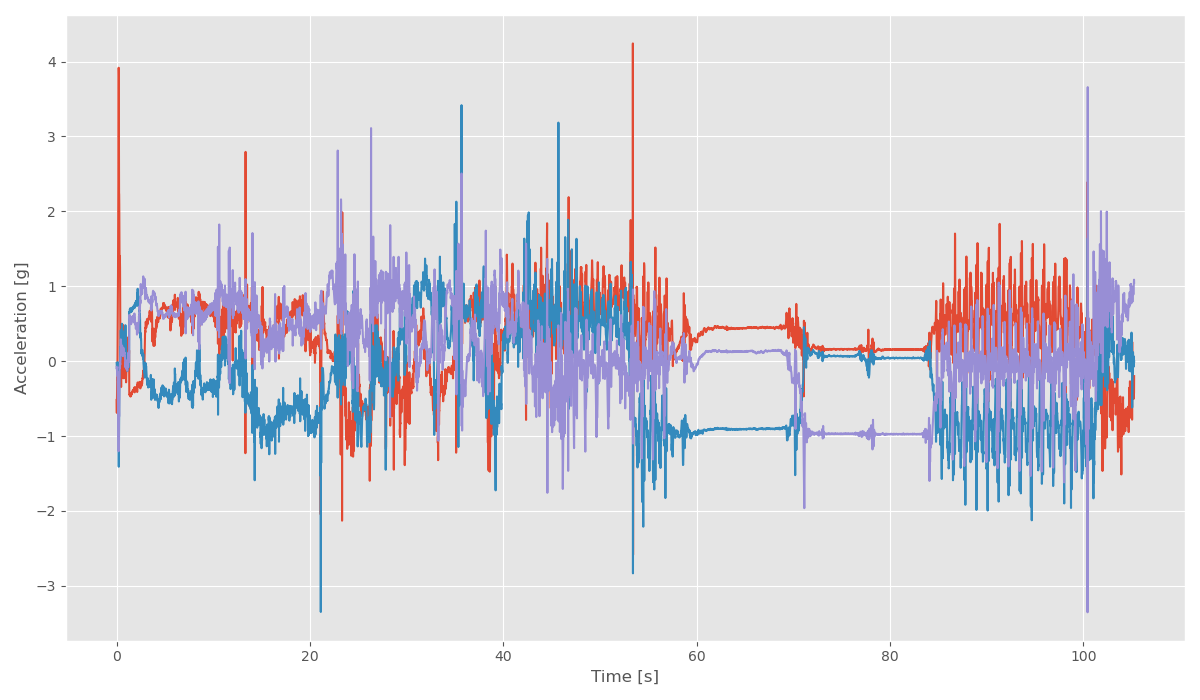

In [9]:
f, ax = plt.subplots(figsize=(12, 7))
ax.plot(exdata_2min['time'] - exdata_2min['time'][0], exdata_2min['accel'])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Acceleration [g]')
f.tight_layout()

We can see what looks like some gait, starting at around the 85 second mark.

# Predicting gait bouts

Lets see if this gets caught by the gait classifier. Again, lets take a look at the arguments:

In [10]:
?skdh.context.PredictGaitLumbarLgbm

Init signature: skdh.context.PredictGaitLumbarLgbm(downsample_aa_filter=True)
Docstring:     
Process lumbar acceleration data to predict bouts of gait using a Light Gradient
Boosted model.

Predictions are computed on non-overlappping 3-second windows.

Parameters
----------
downsample_aa_filter : bool, optional
    Apply an anti-aliasing filter when downsampling accelerometer data. Default
    is True.
Init docstring:
Intended to be subclassed

Parameters
----------
return_result : bool, optional
    Return the result part of predict, or the input/output dictionary
kwargs
    Key-word arguments which are passed to the sub-class
File:           ~/opt/miniconda3/envs/skdh/lib/python3.12/site-packages/skdh/context/gait_classification.py
Type:           type
Subclasses:     

In [11]:
gait_cls = skdh.context.PredictGaitLumbarLgbm(downsample_aa_filter=True)
gait_cls_res = gait_cls.predict(
    time=exdata_2min['time'],
    accel=exdata_2min['accel'],
    fs=exdata_2min['fs'],
)
gait_cls_res

{'Gait Bout Start': array([1.57233984e+09, 1.57233987e+09]),
 'Gait Bout Stop': array([1.57233984e+09, 1.57233989e+09]),
 'Gait Bout Start Index': array([5400, 8400]),
 'Gait Bout Stop Index': array([5700, 9900]),
 'Timezone': None}

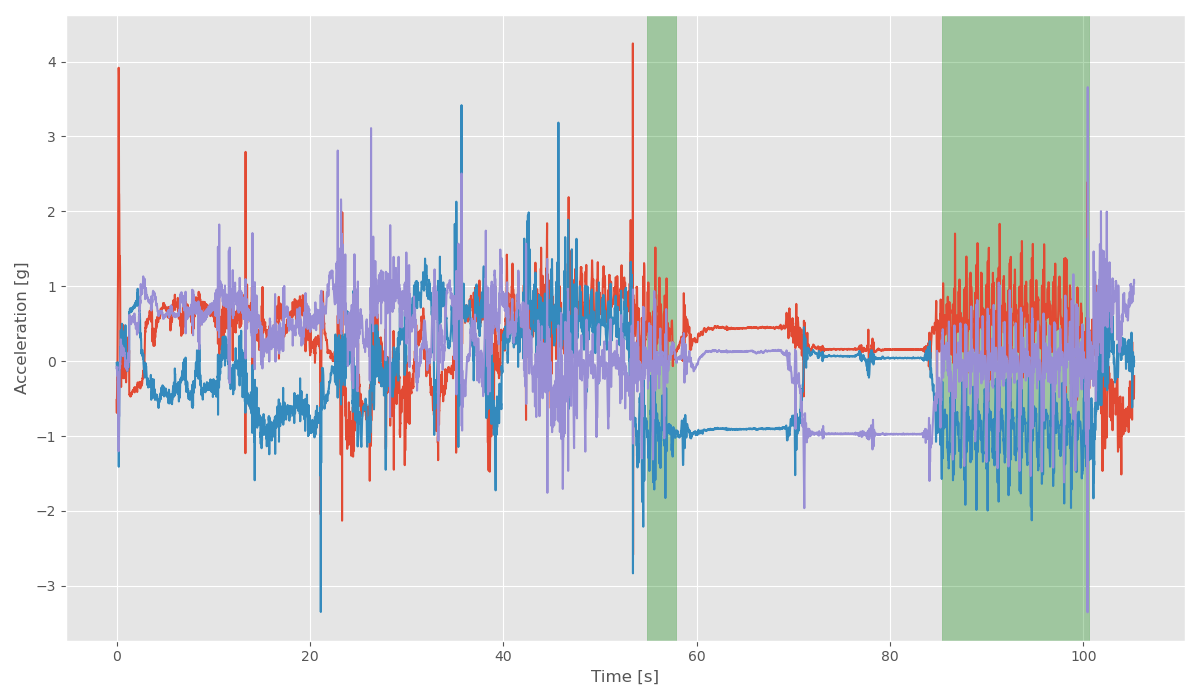

In [12]:
f, ax = plt.subplots(figsize=(12, 7))
ax.plot(exdata_2min['time'] - exdata_2min['time'][0], exdata_2min['accel'])
for start, stop in zip(gait_cls_res['Gait Bout Start'], gait_cls_res['Gait Bout Stop']):
    ax.axvspan(start - exdata_2min['time'][0], stop - exdata_2min['time'][0], color='g', alpha=0.3)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Acceleration [g]')
f.tight_layout()

We can see that there were two chunks of walking detected, a 3 second window just before 60 seconds, and a 12 second window where we expected, right after 80 seconds. Internally, we typically exclude gait bouts that are less than 9 seconds long, so the first window will usually be discarded and no steps/gait endpoints estimated. However the second window is plenty long enough, and we can calculate gait metrics here.

# Estimating gait metrics

We'll leave most of the parameters as their defaults for now, and just initialize the class for processing.

In [13]:
gait_proc = skdh.gait.GaitLumbar()

Lets take a look at the `predict` method so we can figure out how to pass the gait bout information in.

In [14]:
?gait_proc.predict

Signature:
gait_proc.predict(
    time=None,
    accel=None,
    *,
    gyro=None,
    fs=None,
    height=None,
    gait_bouts=None,
    gait_pred=True,
    v_axis=None,
    ap_axis=None,
    tz_name=None,
    **kwargs,
)
Docstring:
predict(time, accel, *, gyro=None, fs=None, height=None, gait_pred=None, v_axis=None, ap_axis=None, tz_name=None)

Get the gait events and endpoints from a time series signal

Parameters
----------
time : numpy.ndarray
    (N, ) array of unix timestamps, in seconds
accel : numpy.ndarray
    (N, 3) array of accelerations measured by a centrally mounted lumbar
    inertial measurement device, in units of 'g'.
gyro : numpy.ndarray
    (N, 3) array of angular velocities measured by a centrally mounted
    lumbar inertial measurement device, in units of 'rad/s'. If provided,
    will be used to indicate if steps occur during turns. Default is None.
fs : float, optional
    Sampling frequency in Hz of the accelerometer data. If not provided,
    will be computed

> gait_bouts : numpy.ndarray, optional
> 
>    (N, 2) array of gait starts (column 1) and stops (column 2). Either this
    or `gait_pred` is required in order to have gait analysis be performed
    on the data. `gait_bouts` takes precedence over `gait_pred`.

This matches up well with our gait outputs, so we can do the following to create a single array of these starts/stops:

In [15]:
gait_bouts = np.hstack(
    (
        gait_cls_res['Gait Bout Start Index'].reshape((-1, 1)),
        gait_cls_res['Gait Bout Stop Index'].reshape((-1, 1))
    )
)
gait_bouts

array([[5400, 5700],
       [8400, 9900]])

From there, we can run the gait predict method:

In [16]:
gait_res = gait_proc.predict(
    **exdata_2min,  # use Python's expanding functionality to pass in all the ingested data at once
    height=1.88,  # in meters
    gait_bouts=gait_bouts,
)

/Users/lukasadamowicz/opt/miniconda3/envs/skdh/lib/python3.12/site-packages/skdh/gait/substeps/s4_turns.py:153: RuntimeWarning: overflow encountered in matmul
  gsR = update_R @ gsR
/Users/lukasadamowicz/opt/miniconda3/envs/skdh/lib/python3.12/site-packages/skdh/gait/substeps/s4_turns.py:153: RuntimeWarning: invalid value encountered in matmul
  gsR = update_R @ gsR


Lets take a look at the results:

In [17]:
pd.DataFrame(gait_res)

,Day N,Date,Processing Start Hour,Processing End Hour,Day Start Timestamp,Day End Timestamp,Bout N,Bout Starts,Bout Duration,Bout Steps,...,intra-step covariance - V,intra-stride covariance - V,harmonic ratio - V,stride SPARC,bout:phase coordination index,bout:gait symmetry index,bout:step regularity - V,bout:stride regularity - V,bout:autocovariance symmetry - V,bout:regularity index - V
0,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.634902,0.292385,0.940236,-3.405011,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
1,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.851358,0.920991,1.579265,-3.501073,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
2,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.805005,0.841201,2.133628,-4.156937,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
3,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.670837,0.867339,1.788334,-4.102523,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
4,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.825914,0.637689,1.768422,-4.228241,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
5,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.915158,0.851831,1.921273,-4.272697,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
6,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.572537,0.904262,1.295913,-4.044478,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
7,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.625414,0.829942,1.371776,-3.685548,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
8,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.696250,0.726553,1.949076,-3.715051,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769
9,1,2019-10-29,0,24,2019-10-29 09:03:06.299999952,2019-10-29 09:04:51.559999943,1,1.572340e+09,15.0,11,...,0.831832,NaN,NaN,NaN,1.667555,0.841662,0.763033,0.76857,0.005537,0.992769


# Combining multiple steps into one pipeline

In the previous steps, we stepped through each individual step for the processing, which required us manually re-using inputs and outputs to previous methods. However, SKDH has a built-in pipeline class that can handle all of this for us - `skdh.Pipeline`

Lets take a look at the documentation: https://scikit-digital-health.readthedocs.io/en/latest/ref/generated/skdh.Pipeline.html#skdh.Pipeline

From the documentation, we can see that we need to:

1. Initialize the pipeline
2. Add our desired steps to the pipeline

In [18]:
pipe = skdh.Pipeline()  # accept defaults, these usually shouldn't change

Now we can add steps using SKDH methods:

In [19]:
pipe.add(
    skdh.io.ReadCSV(
        time_col_name="timestamp",
        column_names={
            "accel": ["accel_x", "accel_y", "accel_z"],
            "gyro": ["gyro_x", "gyro_y", "gyro_z"],
        },
        drop_duplicate_timestamps=True,
        trim_keys=None,
        fill_gaps=False,
        gaps_error='raise',
        to_datetime_kwargs={
            "unit": "s",
        },
        raw_conversions=None,
        read_csv_kwargs={
            "header": None,
            "names": ["timestamp", "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"],
        }
    )
    # we're not concerned about the name, or saving any results since this is the raw file
)
pipe.add(skdh.context.PredictGaitLumbarLgbm(downsample_aa_filter=True))
pipe.add(skdh.gait.GaitLumbar())

Alternatively, we can add previously initialized methods. This is handy if you want to define methods above with a lot of parameters (such as the `ReadCSV` method), or re-use steps across multiple pipelines. When adding methods, the `make_copy=True` parameter makes sure that methods are copied into new pipelines, and not just referrenced, potentially leading to modifications when or if they are utilized multiple times and some state variables potentially change.

In [20]:
pipe = skdh.Pipeline()
pipe.add(rdr)
pipe.add(gait_cls)
# we'll add the gait process next in a moment

Lets also take a look at the additional arguments to the `add` method:

In [21]:
?pipe.add

Signature:
pipe.add(
    process,
    name=None,
    save_file=None,
    plot_file=None,
    make_copy=True,
)
Docstring:
Add a processing step to the pipeline

Parameters
----------
process : Process
    Process class that forms the step to be run
name : str, optional
    Process name. Used to delineate multiple of the same process if
    required. Output results will be under this name. If None is provided,
    output results will be under the class name, with some mangling in the
    case of multiple of the same processes in the same pipeline.
save_file : {None, str}, optional
    Optionally formattable path for the save file. If left/set to None,
    the results will not be saved anywhere.
plot_file : {None, str}, optional
    Optionally formattable path for the output of plotting. If left/set
    to None, the plot will not be generated and saved.
make_copy : bool, optional
    Create a shallow copy of `process` to add to the pipeline. This allows
    a single instance to be used i

Of particular interest here are the `save_file` and `plot_file` methods. These are arguments that when provided an appropriate file name (`*.csv` and `*.pdf` respectively) that some methods can take advantage of to automatically save the results into. In the case of gait, plotting is only enabled for short files, of which our current example is too long for. However, we can still automatically save the results. In the notes, we can also see that there is some automatic formatting we can also enable, which is useful when batch processing files. 

In this case, we'll save the results to the filename `example_data_2min_gait-results.csv` as follows:

In [22]:
pipe.add(
    gait_proc,
    save_file="{file}_gait-results.csv"
)

Now we can run the whole pipeline and generate results. Note that originally, we passed in `height` just to the gait processing method, while here we can pass it to the pipeline itself and it will get propagated through the entire pipeline, to the gait processing.

In [23]:
pipe_res = pipe.run(
    file=path_example_2min,
    fs=100.0,
    height=1.88
)

/Users/lukasadamowicz/opt/miniconda3/envs/skdh/lib/python3.12/site-packages/skdh/gait/substeps/s4_turns.py:153: RuntimeWarning: overflow encountered in matmul
  gsR = update_R @ gsR
/Users/lukasadamowicz/opt/miniconda3/envs/skdh/lib/python3.12/site-packages/skdh/gait/substeps/s4_turns.py:153: RuntimeWarning: invalid value encountered in matmul
  gsR = update_R @ gsR


We can see that our results contains results for all 3 methods that we ran, as dictionary keys with the method names:

In [24]:
pipe_res

{'ReadCSV': {'accel': array([[-0.518555, -0.023926, -0.077148],
         [-0.641113, -0.048828, -0.102051],
         [-0.690918, -0.088379, -0.094727],
         ...,
         [-0.443359,  0.001953,  1.029785],
         [-0.419434,  0.016113,  1.086914],
         [-0.200684, -0.005859,  1.046387]]),
  'gyro': array([[ -66.223145,  -27.221678,  104.73632 ],
         [ -66.223145,  -27.221678,  104.73632 ],
         [ -64.63623 ,  -27.038572,  104.187004],
         ...,
         [  -5.92041 , -171.020493,   51.452633],
         [ -21.179197, -176.025375,   25.451658],
         [ -41.809078, -168.090805,   16.479492]]),
  'time': array([1.57233979e+09, 1.57233979e+09, 1.57233979e+09, ...,
         1.57233989e+09, 1.57233989e+09, 1.57233989e+09]),
  'fs': 100.0},
 'PredictGaitLumbarLgbm': {'Gait Bout Start': array([1.57233984e+09, 1.57233987e+09]),
  'Gait Bout Stop': array([1.57233984e+09, 1.57233989e+09]),
  'Gait Bout Start Index': array([5400, 8400]),
  'Gait Bout Stop Index': array([57

We can also see that our gait results were saved to the file name we specified:

![gait results file](images/gait_results_file.png "Gait results file")

And the results themselves:

![SKDH gait results](images/gait_results_excel.png "Gait results")

Of note is that since the file was saved automatically by SKDH in the pipeline, there is additional meta-data in the file header, namely the SKDH version used to generate the results, the date the results were generated, and the arguements used specifically for the process that was used to generate those results, in this case the `GaitLumbar` method.

# Saving and loading pipelines

The ability to accumulate multiple processing steps into one pipeline is not the only benefit of pipelines in SKDH. Pipelines also have the ability to save and load their steps into a file, for either record-keeping, or enabling generic code to run any processing pipeline. This last feature comes in handy when setting up a generic framework for processing any inputs with any SKDH pipeline, such as might be required for any distributed, parallel, or cloud processing of handling arbitrary data sources with different processing needs.

First, lets take a look at saving an already created pipeline:

In [25]:
?pipe.save

Signature: pipe.save(file)
Docstring:
Save the pipeline to a file for consistent pipeline generation.

Parameters
----------
file : {str, path-like}
    File path to save the pipeline structure to
File:      ~/opt/miniconda3/envs/skdh/lib/python3.12/site-packages/skdh/pipeline.py
Type:      method

In [26]:
# the extension is somewhat arbitrary - the file contents are just a 
# yaml specification of the pipeline
pipe.save("gait_pipeline.skdh")

![SKDH saved pipeline](images/skdh_pipeline_save.png "SKDH saved pipeline")

We can see all our parameters that we specified saved in the file, and we could load this file again, and return the same pipeline we created above:

In [27]:
pipe2 = skdh.Pipeline(load_kwargs={"file": "gait_pipeline.skdh"})

We can check this version of the pipeline's signature to see if it loaded correctly:

In [28]:
pipe2

IMUAnalysisPipeline[
	ReadCSV(time_col_name='timestamp', column_names={'accel': ['accel_x', 'accel_y', 'accel_z'], 'gyro': ['gyro_x', 'gyro_y', 'gyro_z']}, drop_duplicate_timestamps=True, trim_keys=None, fill_gaps=False, fill_value=None, gaps_error='raise', to_datetime_kwargs={'unit': 's', 'utc': False}, raw_conversions=None, read_csv_kwargs={'header': None, 'names': ['timestamp', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']}, ext_error='warn'),
	PredictGaitLumbarLgbm(downsample_aa_filter=True),
	GaitLumbar(downsample=False, height_factor=0.53, provide_leg_length=False, min_bout_time=8.0, max_bout_separation_time=0.5, gait_event_method='AP CWT', correct_orientation=True, filter_cutoff=20.0, filter_order=4, ap_axis_filter_kw=None, ic_prom_factor=0.6, ic_dist_factor=0.5, fc_prom_factor=0.6, fc_dist_factor=0.6, use_cwt_scale_relation=True, wavelet_scale='default', round_scale=False, max_stride_time='default', loading_factor='default', bout_processing_pipeline=None, day_w

We can see our 3 methods specified, and the parameters match what we specified above again.

# Generic processing of any files with any SKDH pipeline

Because we can load pipelines like this, it means that setting up code to process arbitrary files with arbitrary pipelines becomes trivial:

In [29]:
%%capture --no-display
"""
Any setup and logistics for the code for processing
"""
# load a SKDH pipeline. The function here would just handle different specification types, ie
# either a file path, or a YAML string, etc
skdh_pipeline = load_pipeline(pipeline_specification)
# run the pipeline, providing the input file, along with any other processing requirements, ie height
# for gait processing
pipeline_results = skdh_pipeline.run(file=input_file, **processing_requirements)
# note that because we can specify the pipeline itself to save the outputs of desired steps,
# there is no need to manually save results from the pipeline itself, though they are all
# present for any additional post-processing desired

NameError: name 'load_pipeline' is not defined

# Advanced use case: Custom file reader

In [30]:
from pyarrow import parquet as pq
import pyarrow as pa

Implementing a custom class that can work within the SKDH framework is also relatively straightforward, as a lot of boilerplate is abstracted out, and handled by methods defined within SKDH. Unfortunately the full process is currently not that well documented, however all modules in SKDH are implemented in this way, and should provide some example. Here, we will see the process for creating a custom reader method to read in data in a parquet file.

The data in the parquet file is the same as the data above, we just follow this example to show how to implement your own custom method, either for your own data types or processing algorithms. The same principals apply to algorithm modules

At the core of SKDH methods is the `BaseProcess` class, which has its own short docstring:

In [31]:
?skdh.BaseProcess

Init signature: skdh.BaseProcess(**kwargs)
Docstring:     
The base class for any Process that is designed to work within the
Scikit-Digital-Health framework, and the Pipeline class. Should be subclassed.
Init docstring:
Intended to be subclassed

Parameters
----------
return_result : bool, optional
    Return the result part of predict, or the input/output dictionary
kwargs
    Key-word arguments which are passed to the sub-class
File:           ~/opt/miniconda3/envs/skdh/lib/python3.12/site-packages/skdh/base.py
Type:           type
Subclasses:     BaseIO, ReadNumpyFile, MultiReader, FillGaps, GetDayWindowIndices, CalibrateAccelerometer, DETACH, CountWearDetection, CtaWearDetection, AccelThresholdWearDetection, ...

In general, for methods intended to interface with other SKDH processes, and the pipelines, they should just be subclasses of this `BaseProcess`. 

However, there is some additional functionality provided by another sub-class of this, specifically for IO methods, called `BaseIO`:

In [32]:
?skdh.io.base.BaseIO

Init signature: skdh.io.base.BaseIO(**kwargs)
Docstring:     
The base class for any Process that is designed to work within the
Scikit-Digital-Health framework, and the Pipeline class. Should be subclassed.
Init docstring:
Intended to be subclassed

Parameters
----------
return_result : bool, optional
    Return the result part of predict, or the input/output dictionary
kwargs
    Key-word arguments which are passed to the sub-class
File:           ~/opt/miniconda3/envs/skdh/lib/python3.12/site-packages/skdh/io/base.py
Type:           type
Subclasses:     ReadCwa, ReadBin, ReadApdmH5, ReadCSV, ReadEmpaticaAvro

Since we are creating a reader process, we will subclass from this class instead. For now, lets pass on everything and see what methods are available from its parent classes

In [33]:
class ReadParquet(skdh.io.base.BaseIO):
    pass

help(ReadParquet)

Help on class ReadParquet in module __main__:

class ReadParquet(skdh.io.base.BaseIO)
 |  ReadParquet(**kwargs)
 |
 |  Method resolution order:
 |      ReadParquet
 |      skdh.io.base.BaseIO
 |      skdh.base.BaseProcess
 |      builtins.object
 |
 |  Methods inherited from skdh.io.base.BaseIO:
 |
 |  trim_data(self, start_key, end_key, tz_name, predict_kw, *, time, **data)
 |      Trim raw data based on provided date-times
 |
 |      Parameters
 |      ----------
 |      start_key : {None, str}
 |          Start key for the provided trim start time.
 |      end_key : {None, str}
 |          End key for the provided trim end time.
 |      tz_name : {None, str}
 |          IANA time-zone name for the recording location. If not provided,
 |          both the `time` array and provided trim times will be assumed to be naive
 |          and in the same time-zone.
 |      predict_kw : dict
 |          Key-word arguments passed to the predict method.
 |
 |  ----------------------------------

So we can see that we have inherited 4 methods we might be interested in, 3 from `BaseProcess` (generally applicable to algorithm modules), and 1 from `BaseIO`:

1. **trim_data (BaseIO)**: this method is a convenience method to trim data to provided timestamps, if necessary.
2. **convert_timestamps (BaseProcess)**: converts epoch timestamps to human readable times, taking into account timezone (if provided).
3. **predict (BaseProcess)**: this is the method we will overwrite to handle what the class actually does.
4. **save_results (BaseProcess)**: this is the method that is used to save results to a file while in a pipeline. It can be overwritten if necessary, however if you return your results in a dictionary that can be converted to a `pandas.DataFrame`, then this method is ready to go without any further modification.

We can now start writing two required methods for a module, `__init__` and `predict`:

In [ ]:
from skdh import handle_process_returns  # if using BaseProcess, import it on this line as well
from skdh.io.base import BaseIO, check_input_file


class ReadParquet(skdh.io.base.BaseIO):
    """
    Here is where we write the docstring for the main class, including parameters passed to the init method.

    Parameters
    ----------
    time_col_name : str
        Name of the time column in the parquet data.
    accel_col_names : list[str]
        List of 3 strings of the X/Y/Z axes acceleration names in the parquet data.
    """
    def __init__(self, time_col_name, accel_col_names, ext_error="warn"):
        # first our call to the init method. This helps define the str/repr for the instance of the class, as well as handles
        # a few other setup tasks for the processes to chain together nicely
        super().__init__(
            time_col_name=time_col_name,
            accel_col_names=accel_col_names,
            ext_error=ext_error
        )

        # make sure we set them so we can use them later
        self.time_col_name = time_col_name
        self.accel_col_names = accel_col_names

        # how to handle file extension errors. More below about where this is checked.
        if ext_error.lower() in ["warn", "raise", "skip"]:
            self.ext_error = ext_error.lower()
        else:
            raise ValueError("`ext_error` must be one of 'raise', 'warn', 'skip'.")

    """
    Additionally to BaseProcess (and BaseIO) there are some helper decorators which help with checking file extensions (and size)
    as well as one to ensure that the process works within the SKDH pipeline framework, handling setting up of returns, so that
    the appropriate outputs get passed to future steps of the pipeline. The two methods respectively are:
    
    - skdh.io.base.check_input_file
    - skdh.base.handle_process_returns
    """
    # handles how results are dealt with. In this case, since we are returning data to be used in future steps, we 
    # want to return them to the key-word arguments (kwargs) that are passed to future steps. You might set this false
    # in the case where you have results for users only that don't get/can't be used by future pipeline steps. In this second case
    # you can either not have any results for the pipeline, or have a special version of the results that is only for the pipeline
    @handle_process_returns(results_to_kwargs=True)
    @check_input_file(".parquet")  # checks for file size (ie does it have enough contents to be worth reading, and file extension)
    # additionally, the ext_error argument to __init__ specifies how differing extensions are handled
    def predict(self, *, file, tz_name=None, **kwargs):
        """
        Doc-string for the predict class. Note the signature, which has a few unique points:

        - * after self: indicates that everything needs to be passed as a key-word argument. This is not strictly necessary
            but helps ensure that everything is passed where intended. Note that because there is no default value for `file`, 
            it is still a mandatory input, but must be specified by name
        - **kwargs: we need this here in case we want to pass information to the pipeline that is used in future steps. Without this,
            this method would raise an error, for example if we passed height information to the `pipeline.run` method, when it tried to 
            pass it to this method, it would raise an error as an unexpected value.

        Parameters
        ----------
        file : Path, str
            Path or string to location of the file to be read
        tz_name : {None, str}, optional
            Official time-zone name to use for the provided timestamps. If none, timestamps are assumed to be naive local.
        """
        super().predict(
            expect_days=False,  # indicates if we are expecting day window indices in this method, and helps handle them, placing the appropriate ones in self.days
            expect_wear=False,  # indicates if wear is expected
            file=file,
            tz_name=tz_name,
            **kwargs
        )

        # read the file using pyarrow
        table = pq.read_table(file)

        # get the time values. In this case, they are already in the appropriate format, so we dont need to do anything. 
        # Do note however, that if a timezone is provided, future steps assume the timestamps are UTC, and convert to local time
        # using the timezone name. Therefor, if you are reading naive local time, and passing in a timezone name, make sure you convert the timestamps
        # to UTC timestmaps so that you get the appropriate times in the results and day windowing is accurate.
        time = table[self.time_col_name].to_numpy()  # convert to numpy as this is expected format

        # handle acceleration
        _data = []
        for k in self.accel_col_names:
            _data.append(table[k].to_numpy())

        accel = np.array(_data)

        # setup the results. Returns should basically always be a dictionary, even if only returning 1 value.
        results = {
            self._time: time,  # self._time is defined as 'time' in skdh, so that its standardized where possible
            self._acc: accel,  # same as _time above
        }

        return results  # because of the decorator above, these are both results, as well as inputs to any future methods in a SKDH pipeline

In [34]:
data = ReadParquet("time", ["acc_x", "acc_y", "acc_z"]).predict(file="example_data_2min.parquet")
data

TypeError: BaseProcess.__init__() takes 1 positional argument but 3 were given